<a href="https://colab.research.google.com/github/SajlaKM/CancerClassifier/blob/main/Segmentation_MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import drive
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

In [2]:

drive.mount('/content/drive')
DATASET_PATH = "/content/drive/MyDrive/GitHub dataset /dataset.zip"
extract_path = "/content/dataset"
with zipfile.ZipFile(DATASET_PATH, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extracted files:", os.listdir(extract_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracted files: ['Training', 'Testing']


In [3]:

image_size = (227, 227)  # As per architecture

# Define training path
train_path = os.path.join(extract_path, "Training")

images = []
labels = []

# Iterate through class folders (e.g., 'glioma', 'meningioma', etc.)
for label in os.listdir(train_path):
    label_path = os.path.join(train_path, label)

    # Ensure it's a directory (to avoid processing files by mistake)
    if not os.path.isdir(label_path):
        continue

    # Process each image inside the class folder
    for img_name in os.listdir(label_path):
        img_path = os.path.join(label_path, img_name)

        # ✅ Skip directories (ensure only image files are processed)
        if os.path.isdir(img_path):
            continue

        try:
            img = load_img(img_path, target_size=image_size)  # Load image
            img_array = img_to_array(img) / 255.0  # Normalize
            images.append(img_array)
            labels.append(label)  # Store class
        except Exception as e:
            print(f"Skipping {img_path}: {e}")  # Handle potential errors

print(f"Total images loaded: {len(images)}")
print(f"Total labels loaded: {len(labels)}")

Total images loaded: 5712
Total labels loaded: 5712


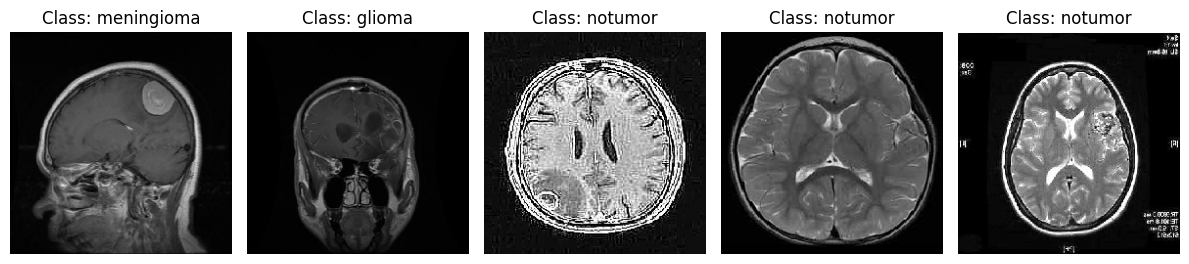

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Convert lists to numpy arrays for easier indexing
images = np.array(images)
labels = np.array(labels)

# Function to Display Sample Images with Labels
def plot_sample_images(images, labels, num_samples=5):
    plt.figure(figsize=(12, num_samples * 3))

    # Randomly select indices for visualization
    indices = np.random.choice(len(images), num_samples, replace=False)

    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[idx])  # Show MRI image
        plt.title(f"Class: {labels[idx]}")  # Display class label
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Plot a few sample MRI images with their class labels
plot_sample_images(images, labels, num_samples=5)

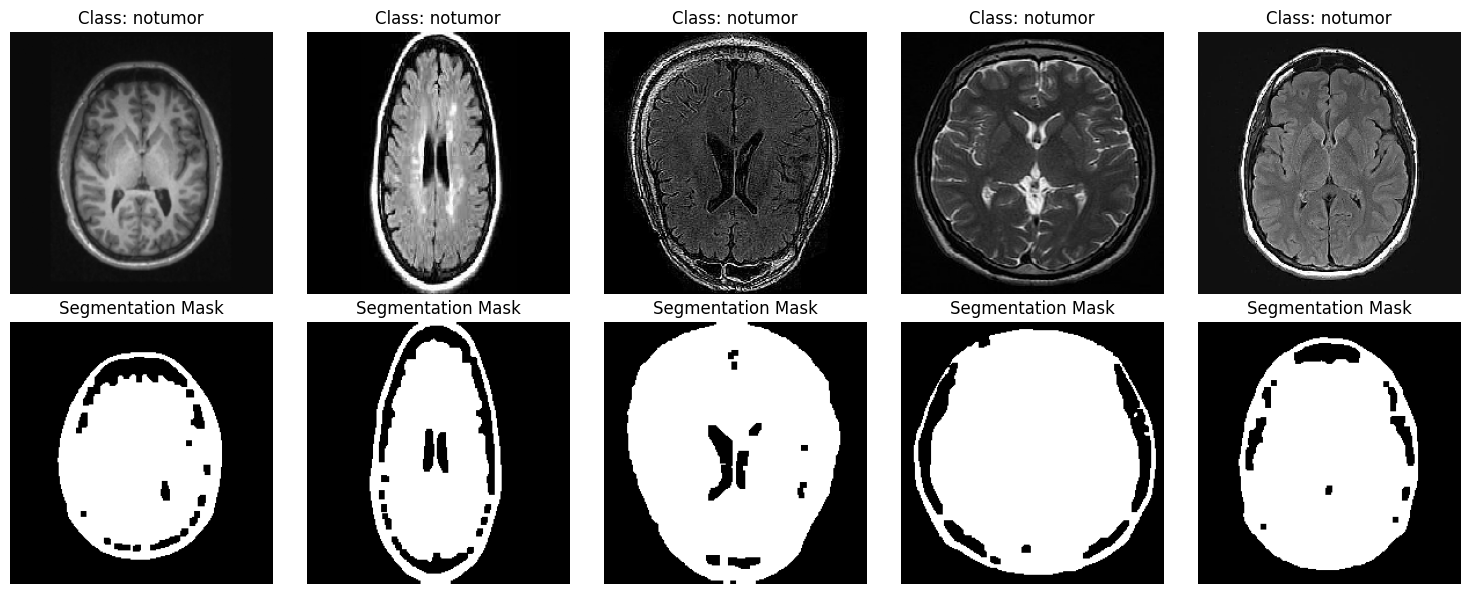

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_segmentation_mask(image):
    """
    Generates a pseudo-segmentation mask using thresholding and edge detection.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian blur to smooth the image
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Use Otsu's thresholding
    _, mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply morphological operations to refine mask
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    return mask

# Filter only 'notumor' images
filtered_images = []
filtered_labels = []
filtered_masks = []

for i in range(len(images)):
    if labels[i] in ["notumor"]:  # ✅ Select only specific classes
        filtered_images.append(images[i])
        filtered_labels.append(labels[i])
        filtered_masks.append(generate_segmentation_mask((images[i] * 255).astype(np.uint8)))

# Number of filtered samples
num_samples = 5

# Plot original images and corresponding masks
fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

for i in range(num_samples):
    # Show MRI image
    axes[0, i].imshow(filtered_images[i])
    axes[0, i].set_title(f"Class: {filtered_labels[i]}")
    axes[0, i].axis("off")

    # Show corresponding mask
    axes[1, i].imshow(filtered_masks[i], cmap="gray")
    axes[1, i].set_title("Segmentation Mask")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

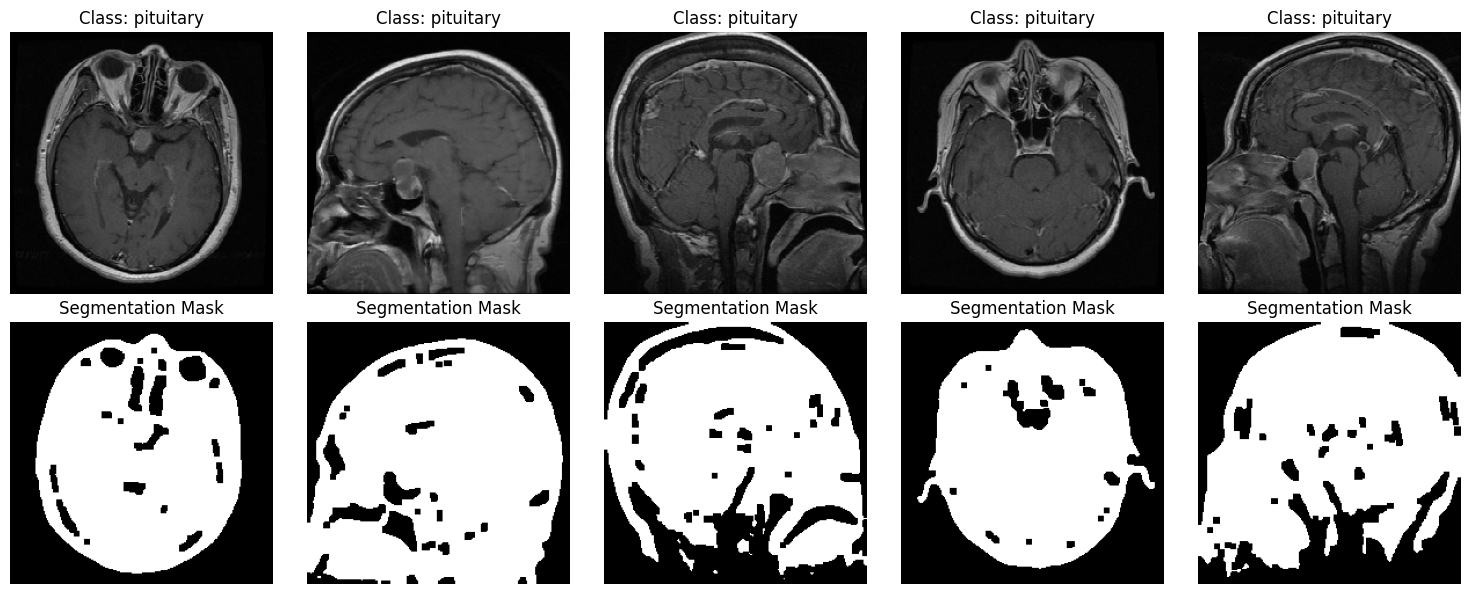

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_segmentation_mask(image):
    """
    Generates a pseudo-segmentation mask using thresholding and edge detection.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian blur to smooth the image
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Use Otsu's thresholding
    _, mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply morphological operations to refine mask
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    return mask

# Filter only 'pituitary' images
filtered_images = []
filtered_labels = []
filtered_masks = []

for i in range(len(images)):
    if labels[i] in ["pituitary"]:  # ✅ Select only specific classes
        filtered_images.append(images[i])
        filtered_labels.append(labels[i])
        filtered_masks.append(generate_segmentation_mask((images[i] * 255).astype(np.uint8)))

# Number of filtered samples
num_samples = 5

# Plot original images and corresponding masks
fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

for i in range(num_samples):
    # Show MRI image
    axes[0, i].imshow(filtered_images[i])
    axes[0, i].set_title(f"Class: {filtered_labels[i]}")
    axes[0, i].axis("off")

    # Show corresponding mask
    axes[1, i].imshow(filtered_masks[i], cmap="gray")
    axes[1, i].set_title("Segmentation Mask")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

In [7]:
print(images.shape)  # Expected output: (num_samples, 256, 256, 1) or (num_samples, 256, 256, 3)

(5712, 227, 227, 3)


In [ ]:
import cv2
import numpy as np

# Resize images to 256x256
images_resized = np.array([cv2.resize(img, (256, 256)) for img in images])

In [ ]:
# Convert RGB to Grayscale
images_gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images_resized])

# Reshape to add the required channel dimension
images_gray = images_gray.reshape(-1, 256, 256, 1)  # Adding single channel

In [ ]:
print(images_gray.shape)  # Expected output: (num_samples, 256, 256, 1)

(5712, 256, 256, 1)


In [8]:
train_dir = os.path.join(extract_path, "Training")
test_dir = os.path.join(extract_path, "Testing")
IMG_SIZE = 256
def load_images_and_masks(directory):
    images = []
    masks = []

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            # Load image
            img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
            img = img_to_array(img).astype(np.uint8)  # Convert to uint8

            # Generate pseudo-mask using thresholding
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            _, mask = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
            mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

            images.append(img)
            masks.append(mask)

    return np.array(images), np.array(masks)

# Set correct directory paths
#train_dir = "/content/brain_tumor_dataset/Training"
#test_dir = "/content/brain_tumor_dataset/Testing"

# Load training and testing data
X_train, y_train = load_images_and_masks(train_dir)
X_test, y_test = load_images_and_masks(test_dir)

print("Data Loaded Successfully!")

Data Loaded Successfully!


In [9]:
# Split training data into train/validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Print dataset shape
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)


Training set: (5140, 256, 256, 3) (5140, 256, 256)
Validation set: (572, 256, 256, 3) (572, 256, 256)
Test set: (1311, 256, 256, 3) (1311, 256, 256)


In [10]:
import tensorflow as tf
from tensorflow.keras import Model, layers, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split

# Define ResUNet Model
def resunet(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)

    def residual_block(x, filters):
        res = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
        res = layers.BatchNormalization()(res)
        res = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(res)
        res = layers.BatchNormalization()(res)
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)
        out = layers.Add()([res, shortcut])
        return layers.ReLU()(out)

    # Encoder
    conv1 = residual_block(inputs, 64)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    conv2 = residual_block(pool1, 128)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    conv3 = residual_block(pool2, 256)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)
    conv4 = residual_block(pool3, 512)

    # Decoder
    up1 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(conv4)
    up1 = layers.Concatenate()([up1, conv3])
    conv5 = residual_block(up1, 256)
    up2 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(conv5)
    up2 = layers.Concatenate()([up2, conv2])
    conv6 = residual_block(up2, 128)
    up3 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(conv6)
    up3 = layers.Concatenate()([up3, conv1])
    conv7 = residual_block(up3, 64)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])
    return model
seg_model = resunet()
seg_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Print model summary
seg_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 64)   │            256 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 64)   │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 256, 256, 64)   │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 128)  │          8,320 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 128, 128, 128)  │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 128, 128, 128)  │            512 │ conv2d_5[0][0]         │
│ (BatchNormalization) 

 Total params: 8,920,065 (34.03 MB)

 Trainable params: 8,911,617 (34.00 MB)

 Non-trainable params: 8,448 (33.00 KB)

In [11]:

# Load Images & Generate Pseudo Masks
def load_images_and_masks(image_folder, target_size=(256, 256)):
    images, masks = [], []
    for file in os.listdir(image_folder):
        img_path = os.path.join(image_folder, file)

        # Read image and check if it is valid
        img = cv2.imread(img_path)
        if img is None:
            print(f"Skipping unreadable file: {img_path}")  # Debugging message
            continue

        img = cv2.resize(img, target_size)
        img = img / 255.0  # Normalize
        images.append(img)

        # Create a pseudo mask (simple thresholding)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)  # Adjust threshold if needed
        masks.append(mask.reshape(target_size + (1,)))

    return np.array(images), np.array(masks)

# Load dataset
image_folder = train_dir  # Update path if needed
X, Y = load_images_and_masks(image_folder)
print(f"Loaded {len(X)} images and {len(Y)} masks")
if len(X) == 0:
   print("No need of MRI segmentation")

Skipping unreadable file: /content/dataset/Training/pituitary
Skipping unreadable file: /content/dataset/Training/glioma
Skipping unreadable file: /content/dataset/Training/notumor
Skipping unreadable file: /content/dataset/Training/meningioma
Loaded 0 images and 0 masks
No need of MRI segmentation


In [12]:
print(X_train.dtype, y_train.dtype)
print(X_train[:5])  # Print first 5 samples
print(y_train[:5])

uint8 uint8
[[[[ 0  0  0]
   [ 0  0  0]
   [ 0  0  0]
   ...
   [ 2  2  2]
   [ 2  2  2]
   [ 2  2  2]]

  [[ 0  0  0]
   [ 0  0  0]
   [ 0  0  0]
   ...
   [ 5  5  5]
   [ 5  5  5]
   [ 5  5  5]]

  [[ 0  0  0]
   [ 0  0  0]
   [ 0  0  0]
   ...
   [ 9  9  9]
   [ 9  9  9]
   [ 9  9  9]]

  ...

  [[ 0  0  0]
   [ 0  0  0]
   [ 0  0  0]
   ...
   [21 21 21]
   [19 19 19]
   [16 16 16]]

  [[ 0  0  0]
   [ 0  0  0]
   [ 0  0  0]
   ...
   [ 6  6  6]
   [ 6  6  6]
   [ 6  6  6]]

  [[ 0  0  0]
   [ 0  0  0]
   [ 0  0  0]
   ...
   [ 4  4  4]
   [ 4  4  4]
   [ 4  4  4]]]


 [[[14 14 14]
   [14 14 14]
   [14 14 14]
   ...
   [13 13 13]
   [14 14 14]
   [15 15 15]]

  [[14 14 14]
   [14 14 14]
   [14 14 14]
   ...
   [14 14 14]
   [15 15 15]
   [15 15 15]]

  [[14 14 14]
   [14 14 14]
   [14 14 14]
   ...
   [15 15 15]
   [16 16 16]
   [16 16 16]]

  ...

  [[15 15 15]
   [14 14 14]
   [13 13 13]
   ...
   [27 27 27]
   [17 17 17]
   [11 11 11]]

  [[16 16 16]
   [16 16 16]
   [16 16 16]


In [13]:
import numpy as np

print(np.unique(y_train))  # This will show all unique values in y_train
print(y_train[:5])  # Print first 5 labels


[  0 255]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


In [15]:
print(X_train.dtype, y_train.dtype)
print(X_train.shape, y_train.shape)  # Should be (samples, height, width, channels)


uint8 uint8
(5140, 256, 256, 3) (5140, 256, 256)
